In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2

from time import time
from subprocess import call
from epsilon.utils import jit_toy_data

# no need to worry about this part, it makes
# subsequent model evaluation runs faster
jit_toy_data()

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,torch,epsilon

Ethen 2017-07-22 16:09:24 

CPython 3.5.2
IPython 6.1.0

numpy 1.13.1
pandas 0.19.2
matplotlib 2.0.0
torch 0.1.12_2
epsilon 0.0.1


Utilize side information, flexible loss function and sequence-based representation. Translate a classic matrix factorization model into a neural network form.

# Linear Regression with PyTorch


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [3]:
# make up some trainig data and specify the type to be float, i.e. np.float32
# We DO not recommend double, i.e. np.float64, especially on the GPU. GPUs have bad
# double precision performance since they are optimized for float32
X_train = np.asarray([3.3, 4.4, 5.5, 6.71, 6.93, 4.168, 9.779, 6.182, 7.59, 
                      2.167, 7.042, 10.791, 5.313, 7.997, 5.654, 9.27, 3.1], dtype = np.float32)
X_train = X_train.reshape(-1, 1)
y_train = np.asarray([1.7, 2.76, 2.09, 3.19, 1.694, 1.573, 3.366, 2.596, 2.53, 
                      1.221, 2.827, 3.465, 1.65, 2.904, 2.42, 2.94, 1.3], dtype = np.float32)

A PyTorch Tensor is conceptually identical to a numpy array: a Tensor is an n-dimensional array, and PyTorch provides many functions for operating on these Tensors. Like numpy arrays, PyTorch Tensors do not know anything about deep learning or computational graphs or gradients; they are a generic tool for scientific computing.

In [4]:
# Convert numpy array to Pytorch Tensors to hold input and outputs
# and wrap them in Variables. Setting requires_grad = False indicates
# that we do not need to compute gradients with respect to these Variables
# during the backward pass
X = Variable(torch.from_numpy(X_train), requires_grad = False)
y = Variable(torch.from_numpy(y_train), requires_grad = False)

In [5]:
# here we start defining the linear regression model

# linear regression is simply applying a linear transformation
# to the incoming data, i.e. y = Ax + b, here we only have a 1
# dimensional data, thus the feature size will be 1
model = nn.Linear(in_features = 1, out_features = 1)

# although we can write our own loss function, the nn module
# also contains definitions of popular loss functions; here
# we use the MSELoss, a.k.a the L2 loss, and size_average parameter
# simply divides it with the number of examples
loss_function = nn.MSELoss(size_average = True)

# Then we use the optim module to define an Optimizer that will update the weights of
# the model for us. Here we will use SGD; but it contains many other
# optimization algorithms. The first argument to the Adam constructor tells the
# optimizer the parameters that it should update
optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [6]:
n_epochs = 100
for i in range(n_epochs):
    # torch accumulates the gradients, thus before running new things
    # use the optimizer object to zero all of the gradients for the
    # variables it will update (which are the learnable weights of the model),
    # think in terms of refreshing the gradients before doing the another round of update
    optimizer.zero_grad()
    
    # forward pass: compute predicted y by passing x to the model
    output = model(X)
    
    # compute and loss function
    loss = loss_function(output, y)
    
    # backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    
    # call the step function on an Optimizer makes an update to its parameters
    optimizer.step()

In [7]:
# to get the weight and bias from the model, we can
# access the state_dict() attribute from the model that
# we've defined
model.state_dict()

OrderedDict([('weight', 
               0.3180
              [torch.FloatTensor of size 1x1]), ('bias', 
               0.3285
              [torch.FloatTensor of size 1])])

In [8]:
# or we could get it from the model's parameter
# which by itself is a generator
param_list = list(model.parameters())
print(param_list[0].data, param_list[1].data)


 0.3180
[torch.FloatTensor of size 1x1]
 
 0.3285
[torch.FloatTensor of size 1]



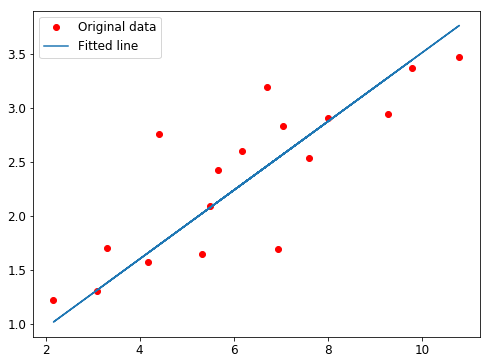

In [9]:
# remember to convert the type from
# torch.FloatTensor to numpy
params = model.state_dict()
weight = params['weight'].numpy()
bias = params['bias'].numpy()

# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

# visualize the fitted line against the original data point
plt.plot(X_train, y_train, 'ro', label = 'Original data')
plt.plot(X_train, weight * X_train + bias, label = 'Fitted line')
plt.legend()
plt.show()

# Recommendation Engine

In [10]:
# download the data if it's not in the same local directory
file_dir = 'ml-100k'
file_path = os.path.join(file_dir, 'u.data')
if not os.path.isdir(file_dir):
    call(['curl', '-O', 'http://files.grouplens.org/datasets/movielens/' + file_dir + '.zip'])
    call(['unzip', file_dir + '.zip'])

In [11]:
from epsilon.utils import check_value_and_coltype

# pass the DataFrame and names of 
# the user, item and ratings columns
user_col = 'user_id'
item_col = 'item_id'
rating_col = 'rating'
timestamp_col = 'timestamp'

names = [user_col, item_col, rating_col, timestamp_col]
df = pd.read_csv(file_path, sep = '\t', names = names)

# this is simply a quick utility function to ensure
# the columns does not include nan values and convert
# type to string if they are not already
df = check_value_and_coltype(df, user_col, item_col)
print('data dimension: \n', df.shape)
df.head()

data dimension: 
 (100000, 4)


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [12]:
from datetime import datetime

def extract_time(row):
    timestamp = datetime.utcfromtimestamp(row)
    time = str(timestamp.year) + ',' + str(timestamp.month)
    return time
    

df[timestamp_col] = df[timestamp_col].apply(extract_time)
df_time = (df[timestamp_col]
           .str.split(',', expand = True)
           .rename(columns = {0: 'year', 1: 'month'}))

for col in df_time.columns:
    df_time[col] = df_time[col].apply(int)

df = df.drop(timestamp_col, axis = 1)
df = pd.concat([df, df_time], axis = 1)

# mask is the watershed for the train/test data
mask = (df['year'] == 1998) & (df['month'] >= 4)
df_train = df[~mask]
df_test = df[mask]

print('training set dimension: ', df_train.shape)
print('testing set dimension: ', df_test.shape)
df_train.head()

training set dimension:  (90641, 5)
testing set dimension:  (9359, 5)


,user_id,item_id,rating,year,month
0,196,242,3,1997,12
2,22,377,1,1997,11
3,244,51,2,1997,11
4,166,346,1,1998,2
5,298,474,4,1998,1


In [20]:
from epsilon.utils import RecommenderMatrix

dtype = 'float32'
rating_threshold = 3
rec_matrix = RecommenderMatrix(
    user_col, item_col, rating_col, dtype, rating_threshold = rating_threshold)

X_train = rec_matrix.fit_transform(df_train)
X_test = rec_matrix.transform(df_test)
X_train

<867x1406 sparse matrix of type '<class 'numpy.float32'>'
	with 50138 stored elements in Compressed Sparse Row format>

In [21]:
X_test

<867x1406 sparse matrix of type '<class 'numpy.float32'>'
	with 1171 stored elements in Compressed Sparse Row format>

In [27]:
from pytorch_rec import Interactions, BaseModule
import torch.utils.data as data

n_users = X_train.shape[0]
n_items = X_train.shape[1]
n_factors = 15
learning_rate = 0.1
#weight_decay = weight_decay
#loss_function = loss_function
n_epochs = 5

batch_size = 10
num_workers = 0
shuffle = True
sparse = False
random_state = 1234

optimizer = torch.optim.Adam
loss_function = nn.MSELoss(size_average = True)

# check if it's possible to use gpu
cuda = torch.cuda.is_available()

In [30]:
row = np.random.randint(n_users)
neg_item = np.random.randint(n_items)
start = X_train.indptr[row]
end = X_train.indptr[row + 1]

In [32]:
indices = X_train.indices[start:end]
indices

array([ 104,  184,  204,  216,  223,  237,  392,  484,  497,  524,  527,
        529,  532,  537,  538,  552,  557,  563,  570,  580,  591,  595,
        596,  599,  604,  613,  618,  620,  621,  638,  654,  665,  700,
        755,  761,  777,  830,  831,  834,  853,  884,  889,  934,  942,
        943,  948,  952,  956,  958,  967,  989, 1013, 1056, 1081, 1097,
       1145, 1226, 1287, 1298, 1364, 1386], dtype=int32)

In [36]:
end - start

61

In [33]:
neg_item

192

In [31]:
searched = np.searchsorted(X_train.indices[start:end], neg_item, 'right')
searched

2

In [16]:
data_train = Interactions(train)
train_loader = data.DataLoader(
    data_train, batch_size = batch_size, shuffle = shuffle, num_workers = num_workers)

In [17]:
model = BaseModule(n_users, n_items, n_factors, sparse)
if cuda:
    model.cuda()

solver = optimizer(model.parameters(), lr = learning_rate)

In [26]:
t = list(model.parameters())

In [27]:
t[0].size()

torch.Size([868, 1])

In [28]:
t[1].size()

torch.Size([1639, 1])

In [29]:
t[2].size()

torch.Size([868, 15])

In [22]:
?np.searchsorted

In [23]:
from tqdm import trange
from torch.autograd import Variable

history = []
loop = trange(n_epochs)
for n_epoch in loop:
    total_loss = torch.FloatTensor([0.0])
    for batch_idx, (row, col, value) in enumerate(train_loader):
        if cuda:
            row, col, value = row.cuda(), col.cuda(), value.cuda()
        
        row = Variable(row, requires_grad = False)
        col = Variable(col, requires_grad = False)
        value = Variable(value, requires_grad = False)
        
        # boilerplate code:
        # 1. refresh gradients
        # 2. conduct forward pass
        # 3. compute loss function
        # 4. perform backward pass
        # 5. do a step and update the weights
        solver.zero_grad()
        output = model(row, col)
        loss = loss_function(output, value)
        loss.backward()
        solver.step()
        total_loss += loss.data[0]
    
    loss = total_loss[0] / len(train_loader)
    # specify loss to display at the end of the progress bar
    loop.set_postfix(loss = loss)
    history.append(loss)

100%|██████████| 5/5 [01:18<00:00, 15.81s/it, loss=246]


In [30]:
history

[214.5266990291262,
 228.3621193733451,
 239.10773389232128,
 238.5614794792586,
 245.89502427184465]

In [25]:
self.model = model(self.n_users,
                           self.n_items,
                           n_factors=self.n_factors,
                           dropout_p=self.dropout_p,
                           sparse=sparse)

NameError: name 'self' is not defined

In [ ]:
pipeline = BasePipeline(train, test=test, model=BaseModule,
                        n_factors=10, batch_size=1024, dropout_p=0.02,
                        lr=0.02, weight_decay=0.1,
                        optimizer=torch.optim.Adam, n_epochs=40,
                        verbose=True, random_seed=2017)
pipeline.fit()

# Reference

- [Blog: Matrix Factorization in PyTorch](http://blog.ethanrosenthal.com/2017/06/20/matrix-factorization-in-pytorch/)
- [Notebook: PyTorch Tensor Basic Usage](http://nbviewer.jupyter.org/github/GunhoChoi/Kind_PyTorch_Tutorial/blob/master/01_Tensor_Basics/pytorch_tensor_basic.ipynb)
- [Notebook: PyTorch Linear Regression](http://nbviewer.jupyter.org/github/GunhoChoi/Kind_PyTorch_Tutorial/blob/master/03_Linear_Regression/Linear_Regression.ipynb)
- [PyTorch Documentation: Learning PyTorch with Examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html)